# 7장 앙상블 학습과 랜덤 포레스트

## 핵심 주제

\예측기의 모음을 **앙상블**(ensemble),
앙상블을 이용한 예측기 학습을 **앙상블 학습**(ensemble learning),
앙상블 학습 알고리즘을 **앙상블 기법**(ensemble method) 등으로 부른다. 

앙상블 기법을 적용하는 다양한 모델, 기법, 알고리즘 등을 살펴본다.

1. 다수결 분류기
1. 배깅/페이스팅
    1. 랜덤 패치와 랜덤 서브스페이스
1. 랜덤 포레스트 
1. 부스팅
    1. 에이다부스트
    1. 그레이디언트 부스팅
1. 스태킹

## 파이썬 기본 설정

* 파이선 버전 3.5 이상
* 사이킷런 버전 0.20 이상
* 모듈 불러오기
    * numpy
    * matplotlib
    * matplotlib.pyplot
* 그림 저장 위치 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 핵심 1: 다수결 분류기

**다수결 분류기**(voting classifier)의 기본 개념은 
동일한 훈련 세트에 대해 여러 종류의 분류기를 학습시킨 후 각 분류기의 예측을 모아
다수결 방식으로 예측값을 결정하는 것이다. 
이와 같이 작동하는 분류기를 **직접 투표**(hard voting) 분류기라 부른다. 

반면에 사용되는 분류기가 모두 클래스에 포함될 확률을 계산하는 `predict_proba()` 메서드를
지원한다면 사용된 분류기의 확률 예측을 평균 내어 가장 높은 확률의 클래스를 선택할 수 있다.
이렇게 작동하는 분류기를 **간접 투표**(soft voting) 분류기라 부른다. 
확류리 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 좀 더 좋은 성능을 발휘한다.

아래 그림은 다수결 분류기의 기본적인 작동과정을 보여준다.

<img src="images/majority_voting.png" style="width:60%">

<그림출처> [mlxtend: EnsembleVoteClassifier](http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/)

다수결 분류기를 사용하면 하나의 성능이 좋은 분류기를 사용하는 것보다 일반적으로
정확한 예측을 한다.
단, 다수결 분류기에 포함된 분류기들 사이의 독립성이 전제되어야 한다. 
독립성이 제대로 보장되지 못하면 다수결 분류기의 성능이 성능이 낮아질 수도 있다.
독립성이 어느 정도 이상 보장된 분류기를 이용하여 앙상블 학습을 하면 보다 좋은 
성능의 분류기가 만들어지는 이유를 확률적으로 설명할 수 있다.

앞면이 나올 확률이 51%로 약간 편향된 동전을 이용하여 동전 던지기 실험을 해보자.

* 동전을 1,000번 던지면 동전의 앞면이 나오는 비율이 50% 이상일 확률은 74.7% 이다.
* 동전을 10,000번 던지면 동전의 앞면이 나오는 비율이 50% 이상일 확률은 97.8% 이다.

**참고**: 위 확률은 이항분포의 누적분포함수를 이용하여 쉽게 계산할 수 있다. 

```
from scipy.stats import binom
1-binom.cdf(499, 1000, 0.51)     # 0.747
1-binom.cdf(4999, 10000, 0.51)   # 0.978
```

아래 코드는 동전 10,000번 던지기를 10번 시행하는 것을
모의실험으로 보여준다. 
앞서 언급한 확률대로라면 10,000번 던지기를 100번 하면 98번 정도는
앞면이 나올 확률이 50% 이상이다. 
따라서 10,000번 던지기를 10번 하면 앞면이 50% 이하로 나오는 일은 사실상 없어야 하는데
아래 모의실험이 이를 뒷받침한다.

그림 저장: law_of_large_numbers_plot


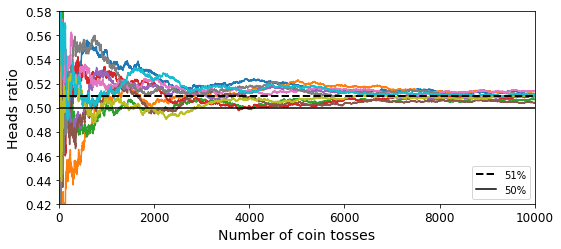

In [2]:
np.random.seed(42)

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

위 결과의 의미는 다음과 같다. 

> 앞면이 나올 확률을 분류기의 정확도라고 하면, 
> 그런 분류기의 성능은 무작위로 찍는 것보다 아주 조금 좋은 정도이다. 
> 그런데 그런 분류기를 1,000 개 사용하여 클래스를 예측하고,
> 가장 많이 예측된 클래스를 최종 선택하면 그 결과가 맞을 확률이 74.7%이고,
> 그런 분류기를 10,000 개 사용하면 정확도가 97.8%까지 올라간다.

물론, 이것은 사용되는 분류기가 완벽하게 서로 독립적이어서 서로의 결과에 어떤 영향도 주지 않아야 한다. 
하지만 동전 던지기와는 달리 동일한 훈련 세트를 사용해야 하는 모델 학습에서는
절대로 그런 상호 독립성을 보장할 수 없다. 
분류기들이 동종의 오차를 만들 가능성이 기본적으로 높기 때문에 앙상블 모델의 정확도는
이론보다 많이 낮아질 수밖에 없다. 

### 사이킷런의 다수결 분류기

사이킷런의 `VotingClassifier`가 다수결 분류기 모델을 제공한다. 
훈련 데이터셋으로 5장에서 사용한 moons 데이터셋이다. 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

다음은 로지스틱 회귀, 랜덤 포레스트, 서포트 벡터머신 세 분류기를 
이용하여 다수결 분류기를 생성한 후 학습한다.

* `voting='hard'`: 직접 투표 방식 선택
    * 간접 투표 방식을 선택하려면 `'hard'` 대신에 `'soft'` 지정해야 함.

**참고**: 사이킷런의 향후 버전과의 호환성을 위해 다음 옵션 인자를 사용함. 
* `solver="lbfgs"`
* `n_estimators=100`
* `gamma="scale"`.

사용된 네 개의 분류기의 성능을 정확도를 이용하여 확인할 수 있다.
다수결 분류기의 정확도가 91.2%로 개별 분류기보다 조금 더 성능이 좋다.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 선형 회귀 
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
# 랜덤 포레스트
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
# 서포트 벡터 머신
svm_clf = SVC(gamma="scale", random_state=42)

# 다수결 불류기
# 직접 투표 방식
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')

# 다수결 분류기 학습
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

# 분류기 별 정확도 측정
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__+':\t', accuracy_score(y_test, y_pred))

LogisticRegression:	 0.864
RandomForestClassifier:	 0.896
SVC:	 0.896
VotingClassifier:	 0.912


간접 투표 방식을 사용하면 정확도가 92%로 조금 더 올라간다.

* SVC 모델의 경우 `predict_proba()` 메서드를 사용하기 위해 
    `probability=True` 옵션 인자를 지정해야 한다. 

In [5]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

# 간접 투표 방식
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__+':\t', accuracy_score(y_test, y_pred))

LogisticRegression:	 0.864
RandomForestClassifier:	 0.896
SVC:	 0.896
VotingClassifier:	 0.92


## 핵심 2: 배깅/페이스팅

훈련 세트의 부분집합을 임의로 구성한 후 동일한 분류기를
생성된 부분 집합을 이용하여 학습시키는 방식으로 앙상블 학습을 진행할 수 있다.
즉, 사용되는 분류기 모델은 하나이지만,
훈련 세트를 임의로 다르게 하여 여러 번 학습시킨다. 

훈련 세트의 부분집합을 임의로 선택할 때 중복 허용 여부에 따라 
앙상블 학습 방식이 달라진다. 

* **배깅**(bootstrap aggregating): 중복 허용 샘플링
* **페이스팅**(pasting): 중복 미허용 샘플링

**참고**: 통계학에서 중복을 허용하는 표본 추출 방식을 **부트스트래핑**(bootstrapping)이라 부른다.

아래 그림은 배깅 방식을 묘사한다.

<img src="images/Bagging.png" style="width:60%">

<그림출처> [WikimediaCommons: Bagging](https://commons.wikimedia.org/wiki/File:Bagging.png)

### 앙상블 학습 예측 방식

앙상블 학습 예측기는 최종적으로 **종합 함수**(aggregation function)가
각 개별기의 결과를 종합해서 최종 예측값을 지정한다.

* 분류 모델의 경우: 직접 투표 방식 사용. 즉, 수집된 예측값들 중에엇 최빈값(mode) 선택.
* 회귀 모델의 경우: 수집된 예측값들의 평균값 선택.

### 편향과 분산

앙상블 학습을 이용한 예측기의 경우 개별 예측기의 경우에 비해
일반적으로 편향은 비슷하지만 분산은 줄어든다.
즉, 과대적합의 위험성이 줄어든다.

반면에 개별 학습기의 경우, 배깅/페이스팅 방식으로 학습하면
전체 훈련 세트를 대상으로 학습한 경우에 비해 
편향이 커지는데, 이는 훈련 세트가 작아지면 학습이 제대로 이루지지 않기 때문에
당연한 결과이다. 즉, 과소적합 위험성이 커질 수밖에 없다.

### 사이킷런의 배깅/페이스팅

사이킷런에서 제공하는 배깅/페이스팅 모델은 다음과 같다.

* 분류 모델: `BaggingClassifier`
* 회귀 모델: `BaggingRegressor`

아래 코드는 의사결정나무를 이용하여 배깅 앙상블 학습을 진행한다.
사용된 모델 옵션은 다음과 같다. 

* `n_estimators=500`: 500개의 의사결정나무 학습기 훈련
* `max_samples=100`: 각각의 의사결정나무 분류기에 사용될 훈련 샘플 수가 100개. 기본값은 1.0
    * 정수일 경우 지정된 수 만큼의 샘플 사용
    * 부동소수점 ($\in [0, 1]$): 지정된 비율만큼의 샘플 사용. 즉, 기본값은 전체 샘플 수만큼 사용.
* `bootstrap=True`: 중복 허용 표본 추출. 기본값은 `True`, 즉, 기본적으로 배깅 지원.
* `n_jobs=-1`: 사용할 코어 수. -1은 가능한 모드 코어 사용.

또한 의사결정나무의 경우처럼 `predict_proba()` 메서드가 지원되는 경우 
자동으로 간접 투표(soft voting) 방식이 사용된다.

In [52]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    # bootstrap=True 가 기본값임.
#     bootstrap=True,
    n_jobs=-1,
    random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

앙상블 학습 결과의 정확도는 90.4%이다.

In [53]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.904


반면에 하나의 의사결정나무의 정확도는 85.6%이다. 

In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))

0.856


#### 분류 그래프 그리기 함수

아래 코드에서 정의된 함수 `plot_decision_boundary` 함수는
지정된 분류기가 지정된 훈련 세트를 대상으로 학습한 결과와 결정경계(decision boundary)를
그래프로 보여준다.

In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

아래 코드는 의사결정나무 하나를 이용한 분류기와 앞서 학습한 배깅 방식 앙상블 학습 결과를 보여준다.

* 왼편 그래프: 의사결정나무 하나로 학습한 분류 결과
* 오른편 그래프: 의사결정나무와 배깅 방식으로 학습한 분류 결과

앙상블 학습의 일반화가 보다 좋으며, 편향은 비슷한 반면에 분산이 더 작다. 

* 편향: 잘못된 예측 정도는 두 방식이 거의 비슷함.
* 분산: 과대적합 정도는 왼편이 보다 강함.

그림 저장: decision_tree_without_and_with_bagging_plot


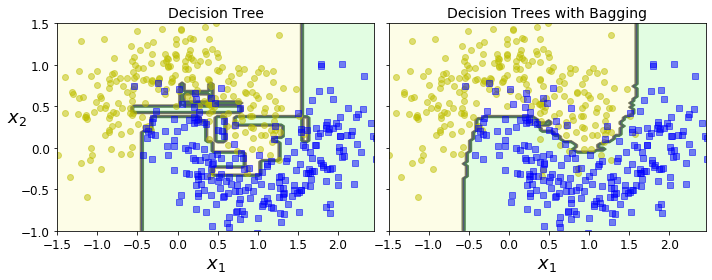

In [10]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

# 왼편 그래프
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

# 오른편 그래프
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)

plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

#### 배깅 대 페이스팅

중복선택을 허용하는 배깅 방식이 사용되는 샘플 부분집합의 다양성을 좀 더 키우며,
다음 효과를 가져온다.

* 일반적으로 배깅 방식이 편향은 키우고, 분산은 줄임.
    * 표본 샘플링의 무작위성을 커지면서 예측기들 사이의 상관관계 정도가 약화되기 때문임.
* 전반적으로 배깅 방식이 좀 더 나은 모델 생성.
* 교차검증을 통해 항상 확인 필요.

### oob 평가

배깅을 사용하면 한 번도 선택되지 못하는 샘플이 존재할 수 있다.
뽑히지 않을 확률을 계산할 수 있으며 이론적으로 37% 정도 된다. 

실제로 $m$ 개의 샘플에서 임의로 선택되지 않을 확률은 $(1 - 1/m)$ 이며,
따라서 중복을 허용하면서 $m$ 번 뽑았을 때 뽑히지 않을 확률은 $(1 - 1/m)^m$ 이다.
이 값은 $m$이 증가함에 따라 0.368에 수렴한다.

$$
\lim_{m\to \infty} (1-1/m)^m = e^{-1} = 0.368
$$

선택되지 않은  훈련 샘플을 **oob(out-of-bag)** 샘플이라고 부른다. 
oob 샘플은 예측기마다 다르며, 예측기가 학습 중에 oob 샘플을 사용하지 않으므로
이 샘플들을 검증 세트로 사용할 수 있다. 
앙상블 모델 자체는 예측비별 oob 평가의 평균값을 이용하여 평가할 수 있다. 

`BaggingClassifier` 의 `oob_score=True` 로 설정하면 oob 평가를 자동으로 실행한다.
평가 점수는 `oob_score_`에 저장된다.

* `max_samples` 옵션이 언급되지 았았기에 `max_samples=1.0` 기본 옵션이 사용된다. 
    즉, 중복을 허용하면서 전체 샘플 수 만큼 표본 추출. 
    전체 데이터의 37% 정도가 oob 샘플이 됨.

In [54]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    bootstrap=True, 
    # max_samples=1.0이 기본값
#     max_samples=1.0
    oob_score=True, 
    random_state=40)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.9013333333333333

oob 평가와 테스트 셋트에 대한 정확도가 비슷하게 나온다.

In [39]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

oob 샘플에 대한 예측값은 클래스에 속할 확률로 구성된다.
`moons` 데이터 셋은 두 개의 클래스로 구성되었기 때문에
각 샘플 별로 길이가 2인 리스트가 된다.

모든 테스트 샘플에 대한 클래스 예측 확률은 `oob_decision_function_` 속성에 저장된다.
처음 10개 샘플에 대한 클래스 예측 확률은 다음과 같다.
예를 들어, 첫째 샘플의 경우 0번(음성) 클래스에 속할 확률은 31.75% 이고
1번(양성) 클래스에 속할 확률은 68.25%이다. 
(클래스별 예측 확률의 합은 1임)

In [40]:
bag_clf.oob_decision_function_[:10]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637]])

### 랜덤 패치/랜덤 서브스페이스

`BaggingClassifier`의 인스턴스 속성 중에서
특성을 대상으로 하는 속성이 두 개 있다.

* `max_features`: 
    * 학습에 사용할 특성 수를 지정. 
    * 특성 선택은 무작위. 
        * 정수인 경우: 지정된 수만큼 특성 선택
        * 부동소수점($\in [0, 1]$)인 경우: 지정된 비율만큼 특성 선택
    * `max_samples`와 유사 기능 수행.
* `bootstrap_features`: 
    * 학습에 사용할 특성을 선택할 때 중복 허용 여부 지정. 
    * 기본값은 `False`.
    * `botostrap`과 유사 기능 수행.
    
이미지 등과 같이 매우 높은 차원의 데이터셋을 다룰 때 유용하게 사용될 수 있다. 
특성 샘플링은 더 다양한 예측기를 만들며, 일반적으로 편향이 커지지만 분산은 낮아진다. 
이유는 보다 적은 수의 특성을 사용하면 아무래도 예측이 부정확해질 수밖에 없는 반면에,
데이터 샘플에 대해 보다 덜 민감하게 반응하게 된다.

훈련 세트와 특성에 대한 샘플링 방식에 따라 아래 두 가지 기법으로 나뉘어진다.

#### 랜덤 패치 기법

훈련 샘플과 훈련 특성 모두를 대상으로 중복을 허용하며 임의의 샘플 수와 임의의 특성 수만큼을 샘플링 해서
학습하는 기법이 **랜덤 패치 기법**이다. 
즉, 다음 두 조건이 참이어야 한다.

* `bootstrap=True` 또는 `max_samples` < 1.0
* `bootstrap_features=True` 또는 `max_features` < 1.0

#### 랜덤 서브스페이스 기법

전데 훈련 세트를 대상으로 삼지만 훈련 특성은 임의의 특성 수만큼 샘플링 해서 
학습하는 기법이 **랜덤 서브스페이스 기법**이다. 
즉, 다음 두 조건이 참이어야 한다.

* `bootstrap=False` 그리고 `max_samples=1.0`
* `bootstrap_features=True` 또는 `max_features` < 1.0

## 핵심 3: 랜덤 포레스트

In [86]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500,
    # max_samples=1.0 이 기본값임.
#     max_samples=1.0, 
    # bootstrap=True 가 기본값임.
#     bootstrap=True,
    n_jobs=-1,
    random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [87]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [88]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

### 특성 중요도

In [17]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [18]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

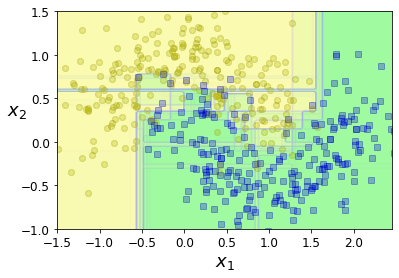

In [19]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Feature importance

In [41]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [42]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


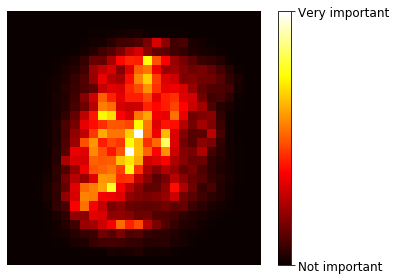

In [44]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

In [ ]:
plot_decision_boundary(ada_clf, X, y)

In [ ]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [ ]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

# Gradient Boosting

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

In [ ]:
min_error = np.min(errors)

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

In [ ]:
print("Minimum validation MSE:", min_val_error)

## Using XGBoost

In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

In [ ]:
voting_clf.score(X_val, y_val)

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [ ]:
voting_clf.set_params(svm_clf=None)

This updated the list of estimators:

In [ ]:
voting_clf.estimators

However, it did not update the list of _trained_ estimators:

In [ ]:
voting_clf.estimators_

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [ ]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [ ]:
voting_clf.score(X_val, y_val)

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

Nope, hard voting wins in this case.

_Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?_

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

The voting classifier only very slightly reduced the error rate of the best model in this case.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

In [ ]:
rnd_forest_blender.oob_score_

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.